# Loading Model Back In

### Load Data Back In

In [13]:
import requests
import tarfile
from pathlib import Path

data_path = Path("/kaggle/working/data")
data_path.mkdir(parents=True, exist_ok=True)
print("Using:", data_path)

url = "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
tgz_path = data_path / "food-101.tar.gz"

print(f"Starting download: {url}")
try:
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        downloaded = 0
        chunk_size = 1024 * 1024  # 1MB

        with open(tgz_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total:
                        pct = downloaded * 100 / total
                        print(f"\rDownloaded {downloaded/1e6:.1f}MB / {total/1e6:.1f}MB ({pct:.1f}%)", end="")
    print("\nDownload finished:", tgz_path)
except Exception as e:
    print("\nDownload failed. On Kaggle, this often means Internet is disabled for the notebook.")
    raise

# Extract
extract_to = Path("/kaggle/working")
print(f"Extracting {tgz_path} to {extract_to} ...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_to)
print("Extraction done.")

# Verify expected folders
directory_name = Path("/kaggle/working/food-101")
print("food-101 exists:", directory_name.exists())
print("images exists:", (directory_name / "images").exists())
print("meta exists:", (directory_name / "meta").exists())

Using: /kaggle/working/data
Starting download: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Downloaded 4996.3MB / 4996.3MB (100.0%)
Download finished: /kaggle/working/data/food-101.tar.gz
Extracting /kaggle/working/data/food-101.tar.gz to /kaggle/working ...
Extraction done.
food-101 exists: True
images exists: True
meta exists: True


In [15]:
# Creating main directory paths
image_path = directory_name / "images"
meta_path = directory_name / "meta"

# Getting list of files in the 'food-101/meta' directory
meta_filenames_list = sorted(list(meta_path.glob("*"))) # ignoring the README file
meta_filenames_list

[PosixPath('/kaggle/working/food-101/meta/classes.txt'),
 PosixPath('/kaggle/working/food-101/meta/labels.txt'),
 PosixPath('/kaggle/working/food-101/meta/test.json'),
 PosixPath('/kaggle/working/food-101/meta/test.txt'),
 PosixPath('/kaggle/working/food-101/meta/train.json'),
 PosixPath('/kaggle/working/food-101/meta/train.txt')]

In [16]:
import json
meta_files_data = []

for file_name in meta_filenames_list:
  if str(file_name)[-5:] == ".json":
    data = json.load(open(file_name))
    meta_files_data.append(data)
  elif str(file_name)[-4:] == ".txt":
    with open(str(file_name), 'r') as f:
      data = [line.strip() for line in f.readlines()]
    meta_files_data.append(data)

# Based the order off of order that file names appear in meta_filenames_list
class_names, labels, \
test_data_paths_dict, test_data_paths_lst, \
train_data_paths_dict, train_data_paths_lst \
= meta_files_data

train_path = image_path / "train"
test_path = image_path / "test"

image_paths_list = list(image_path.glob("*/*.jpg"))
image_paths_list[0], len(image_paths_list)

(PosixPath('/kaggle/working/food-101/images/hot_and_sour_soup/3662301.jpg'),
 101000)

### Load Model Architecture

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall

def build_model(num_classes: int):
    base = EfficientNetB2(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3),
    )

    for layer in base.layers[:-5]:
        layer.trainable = False

    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

### Load Weights and History

In [18]:
import pickle as pkl
from pathlib import Path

RESULTS_PATH = Path("/kaggle/input/datasets/radioapple/effnetb2-model-5-results/kaggle/working/effnetb2_model_5_results")
MODEL_NO = 5  # change if needed

weights_path = RESULTS_PATH / f"model_{MODEL_NO}"
history_path = RESULTS_PATH / f"history_{MODEL_NO}"
opt_path     = RESULTS_PATH / f"opitimizer_{MODEL_NO}"  # note the misspelling matches your save

with open(weights_path, "rb") as f:
    saved_weights = pkl.load(f)

with open(history_path, "rb") as f:
    saved_history = pkl.load(f)

# rebuild + restore
my_model = build_model(num_classes=len(class_names))
my_model.set_weights(saved_weights)

print("Loaded weights. History keys:", saved_history["history"].keys())

31790344/31790344 [==============================] - 0s 0us/step
Loaded weights. History keys: dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


### Test Data Generator

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from keras.utils import load_img
import tensorflow as tf

BATCH_SIZE = 32
SEED = 10
test_size = 0.25
input_size = 224
data_dir = "/kaggle/working/food-101/images"

test_datagen = ImageDataGenerator(validation_split = test_size)

test_gen = test_datagen.flow_from_directory(data_dir,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    target_size = (input_size, input_size),
    shuffle = False,
    class_mode = 'categorical',
    subset = 'validation',
    seed = SEED)

Found 25250 images belonging to 101 classes.


### Evaluating Model on Test Set

In [21]:
results = my_model.evaluate(test_gen, verbose=1)
print(dict(zip(my_model.metrics_names, results)))

790/790 [==============================] - 1772s 2s/step - loss: 1.0983 - accuracy: 0.7317 - precision: 0.8180 - recall: 0.6850
{'loss': 1.0982820987701416, 'accuracy': 0.7316831946372986, 'precision': 0.8180398941040039, 'recall': 0.6849504709243774}


### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_prob = my_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes  # integers aligned with class_indices because shuffle=False

print("Accuracy (from preds):", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

790/790 [==============================] - 1793s 2s/step
Accuracy (from preds): 0.7316831683168317
Confusion matrix shape: (101, 101)


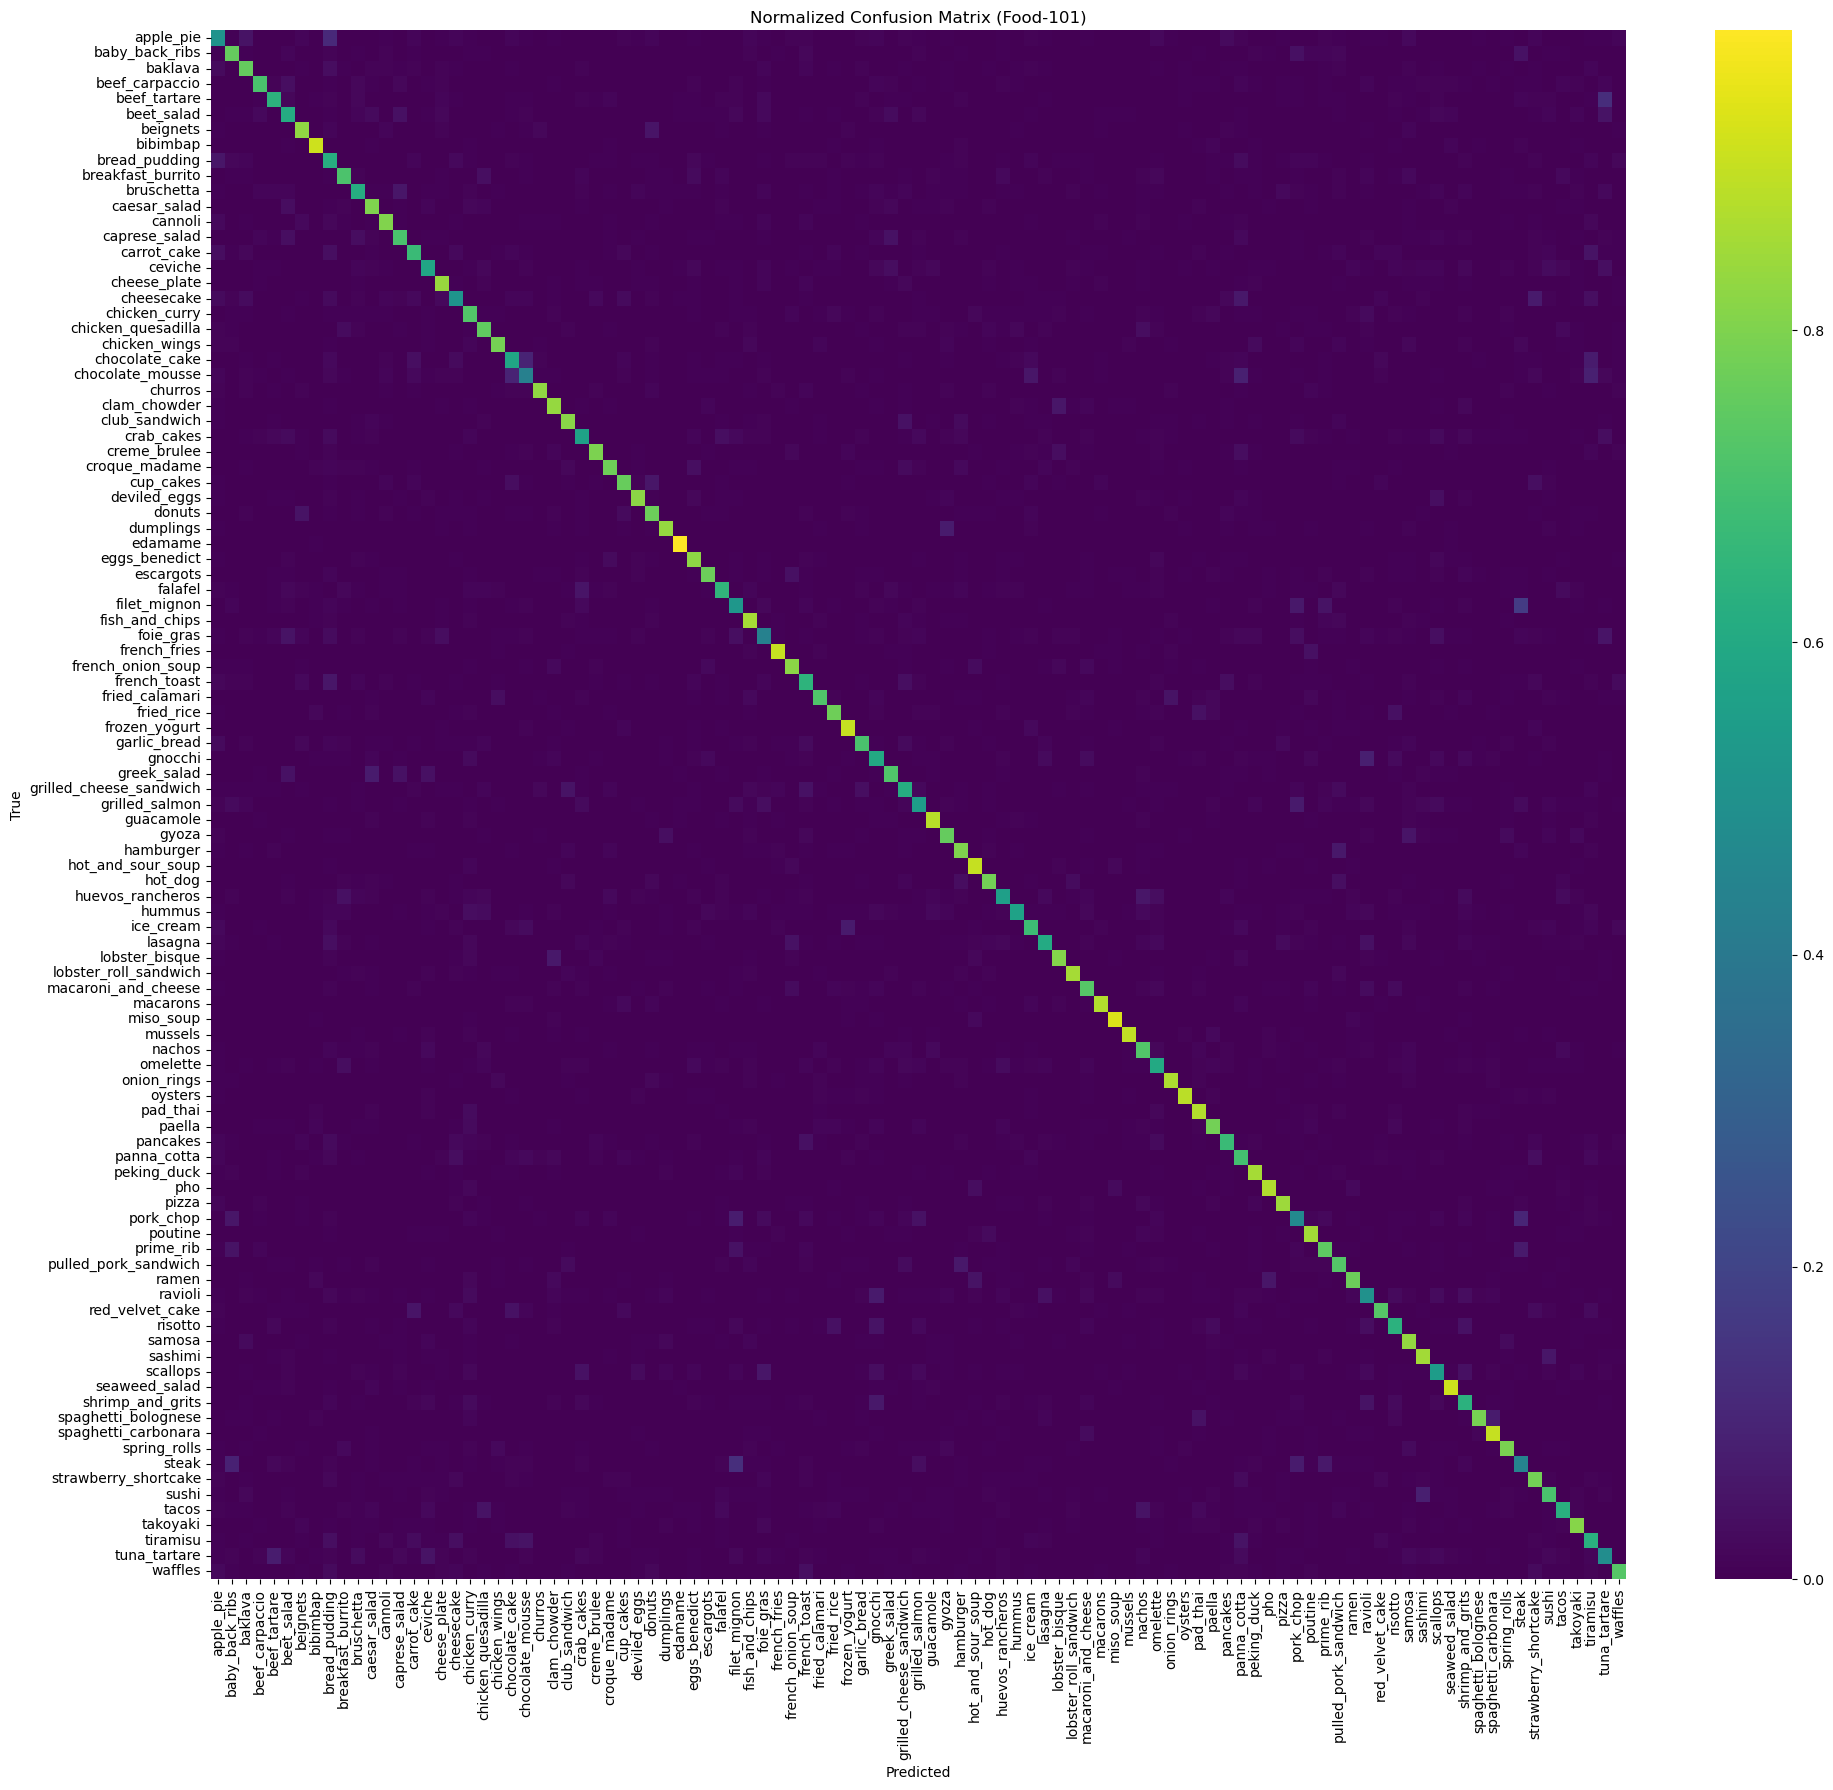

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Normalize for readability
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Get class names in correct order
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm_norm,
    cmap="viridis",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=True
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix (Food-101)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [28]:
cm_norm

array([[0.508, 0.004, 0.048, ..., 0.004, 0.004, 0.012],
       [0.004, 0.756, 0.004, ..., 0.   , 0.   , 0.   ],
       [0.024, 0.   , 0.756, ..., 0.012, 0.   , 0.   ],
       ...,
       [0.004, 0.   , 0.004, ..., 0.628, 0.   , 0.   ],
       [0.004, 0.008, 0.   , ..., 0.012, 0.484, 0.   ],
       [0.02 , 0.004, 0.   , ..., 0.008, 0.   , 0.732]])

### Classification Report

In [24]:
from sklearn.metrics import classification_report

idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
target_names = [idx_to_class[i] for i in range(test_gen.num_classes)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

                         precision    recall  f1-score   support

              apple_pie     0.5100    0.5080    0.5090       250
         baby_back_ribs     0.6799    0.7560    0.7159       250
                baklava     0.7214    0.7560    0.7383       250
         beef_carpaccio     0.8349    0.7080    0.7662       250
           beef_tartare     0.7227    0.6360    0.6766       250
             beet_salad     0.6000    0.6120    0.6059       250
               beignets     0.7841    0.8280    0.8054       250
               bibimbap     0.8842    0.9160    0.8998       250
          bread_pudding     0.4318    0.6200    0.5090       250
      breakfast_burrito     0.7417    0.7120    0.7265       250
             bruschetta     0.6754    0.6160    0.6444       250
           caesar_salad     0.7117    0.8000    0.7533       250
                cannoli     0.8340    0.8040    0.8187       250
          caprese_salad     0.7166    0.7080    0.7123       250
            carrot_cake 